# Análisis Exploratorio de Datos - Data set de OpenSky Network

En este apartado se analizan los datos ya procesados y limpios para responder a las preguntas que nos hicimos antes de comenzar con este trabajo. Para ello, vamos a centrarnos en analizar los vuelos que tienen como origen, destino o ambos, una localidad del territorio Español. Vamos a descubrir como los vuelos han ido variando durante los años 2019 y 2020 con datos reales de los vuelos. 

Para este análisis, vamos a asumir los dos tipos de vuelos más comunes, comeriales y de pasajeros. Existen vuelos militares, vuelos de aerolíneas privadas, vuelos gubernamentales, entre otros. Pero, como veremos, estos otros tipos de vuelos representan una cantidad muy pequeña en los resultados finales.

## Lectura de datos

Empezaremos por explorar cada una de las variables que componen el conjunto de datos. Al reducir el espectro del análisis de los vuelos a solo los vuelos con origen o destino en España, podemos cargar todos los datos en un solo archivo y trabajar con un único data set, lo que va a facilitar el análisis de los datos.

In [6]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import reverse_geocoder as rg
import math

In [8]:
# read all data files and make unique dataframe
df_esp = pd.DataFrame()
for i in range(28):
    df = pd.read_csv(('input_data_clean/{}_clean.csv.gz').format(i+1), sep=',', encoding='utf-8',)
    print('FILE: ',i+1,'-DONE- ###############################')
    esp_fl = df[(df['origin_country']=='Spain') | (df['destination_country']=='Spain')]
    df_esp = pd.concat([df_esp,esp_fl], axis=0,)

# rename some columns
df_esp.columns = ['date', 'latitude_1', 'longitude_1', 'latitude_2', 'longitude_2',
                  'airline', 'airline_country', 'origin_region', 'destination_region',
                  'origin_city', 'destination_city', 'origin_continent', 'origin_country',
                  'destination_continent', 'destination_country']

# create new useful columns
df_esp.reset_index(drop=True, inplace=True)
df_esp['date'] = pd.to_datetime(df_esp['date'])
df_esp['year_'] = df_esp['date'].apply(lambda x: x.year)
df_esp['month_'] = df_esp['date'].apply(lambda x: x.month)
df_esp['day_'] = df_esp['date'].apply(lambda x: x.day)
df_esp['flights'] = 1

# save result file
df_esp.to_csv('input_data_clean/all_spain_flights.csv.gz', sep=',', index=False,encoding='utf-8')

FILE:  1 -DONE- ###############################
FILE:  2 -DONE- ###############################
FILE:  3 -DONE- ###############################
FILE:  4 -DONE- ###############################
FILE:  5 -DONE- ###############################
FILE:  6 -DONE- ###############################
FILE:  7 -DONE- ###############################
FILE:  8 -DONE- ###############################
FILE:  9 -DONE- ###############################
FILE:  10 -DONE- ###############################
FILE:  11 -DONE- ###############################
FILE:  12 -DONE- ###############################
FILE:  13 -DONE- ###############################
FILE:  14 -DONE- ###############################
FILE:  15 -DONE- ###############################
FILE:  16 -DONE- ###############################
FILE:  17 -DONE- ###############################
FILE:  18 -DONE- ###############################
FILE:  19 -DONE- ###############################
FILE:  20 -DONE- ###############################
FILE:  21 -DONE- ############

In [9]:
df_esp = pd.read_csv('input_data_clean/all_spain_flights.csv.gz', sep=',', encoding='utf-8',)
df_esp['date'] = pd.to_datetime(df_esp['date'])

In [10]:
df_esp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987732 entries, 0 to 1987731
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   latitude_1             float64       
 2   longitude_1            float64       
 3   latitude_2             float64       
 4   longitude_2            float64       
 5   airline                object        
 6   airline_country        object        
 7   origin_region          object        
 8   destination_region     object        
 9   origin_city            object        
 10  destination_city       object        
 11  origin_continent       object        
 12  origin_country         object        
 13  destination_continent  object        
 14  destination_country    object        
 15  year_                  int64         
 16  month_                 int64         
 17  day_                   int64         
 18  flights               

Hemos añadido la columna ***flights*** con un **1** en cada registro, de tal manera que sera la columna que utilizaremos para computar el vuelo y agregar valores entre vuelos con características similares.

Así mismo, hemos añadido columas para el año, mes y dia del vuelo (***year_, month_, day_***)

In [4]:
pd.set_option('max_columns', None)
df_esp.head()

,date,latitude_1,longitude_1,latitude_2,longitude_2,airline,airline_country,origin_region,destination_region,origin_city,destination_city,origin_continent,origin_country,destination_continent,destination_country,year_,month_,day_,flights
0,2019-01-01,-37.692123,144.841997,41.036124,2.063557,Air China,China,Victoria,Catalonia,Melbourne,Barcelona,Oceania,Australia,Europe,Spain,2019,1,1,1
1,2019-01-02,60.626541,41.002776,40.483418,-3.546173,Air China,China,Arkhangelskaya,Madrid,Podyuga,Madrid,Europe,Russian Federation,Europe,Spain,2019,1,2,1
2,2019-01-02,40.535614,-3.558960,54.301835,90.041282,Air China,China,Madrid,Khakasiya,Madrid,Tuim,Europe,Spain,Europe,Russian Federation,2019,1,2,1
3,2019-01-03,58.353378,42.201942,40.486237,-3.549037,Air China,China,Kostroma,Madrid,Galich,Madrid,Europe,Russian Federation,Europe,Spain,2019,1,3,1
4,2019-01-04,-37.690430,144.841705,41.064423,2.037415,Air China,China,Victoria,Catalonia,Melbourne,Barcelona,Oceania,Australia,Europe,Spain,2019,1,4,1


Por otro lado, vamos a cargar un archivo con los datos de covid en diferentes paises Europeos para ver la correlación entre la cantidad de vuelos entre paises y los casos de covid en cada uno. Para ello hemos creado un archivo con los casos de covid diarios por país sacados de la siguiente fuente https://ourworldindata.org/. Los países son **España, Francia, Alemania, Holanda, Italia y Portugal**; para cada uno de ellos se ha calculado la incidencia acomulada a 14 días con los datos públicos de la fuente y el censo de la población del país a fecha 1 de Enero de ese año. El periodo de estudio va desde Febrero de 2019 a Abril de 2021 incluidos.

In [5]:
df_covid_eu = pd.read_csv('aux_files/covid_cases_hist.csv', sep=';', index_col='date', encoding='utf-8',parse_dates=True,dayfirst=True)

In [6]:
df_covid_eu.head()

,cases_esp,cases_14d_esp,cases_14d_100k_hab_esp,cases_uk,cases_14d_uk,cases_14d_100k_hab_uk,cases_fr,cases_14d_fr,cases_14d_100k_hab_fr,cases_gr,cases_14d_gr,cases_14d_100k_hab_gr,cases_it,cases_14d_it,cases_14d_100k_hab_it,cases_nt,cases_14d_nt,cases_14d_100k_hab_nt,cases_pt,cases_14d_pt,cases_14d_100k_hab_pt
date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,16,0,0.0,0,0,0.0,1,0,0.0,3,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2020-02-02,10,0,0.0,0,0,0.0,0,0,0.0,2,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2020-02-03,11,0,0.0,0,0,0.0,0,0,0.0,2,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2020-02-04,9,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2020-02-05,6,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0


In [7]:
df_covid_eu = df_covid_eu[['cases_14d_100k_hab_esp', 
                           'cases_14d_100k_hab_uk', 
                           'cases_14d_100k_hab_fr', 
                           'cases_14d_100k_hab_gr', 
                           'cases_14d_100k_hab_it', 
                           'cases_14d_100k_hab_nt', 
                           'cases_14d_100k_hab_pt']]

In [8]:
df_covid_eu.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    455 non-null    datetime64[ns]
 1   cases_14d_100k_hab_esp  455 non-null    float64       
 2   cases_14d_100k_hab_uk   455 non-null    float64       
 3   cases_14d_100k_hab_fr   455 non-null    float64       
 4   cases_14d_100k_hab_gr   455 non-null    float64       
 5   cases_14d_100k_hab_it   455 non-null    float64       
 6   cases_14d_100k_hab_nt   455 non-null    float64       
 7   cases_14d_100k_hab_pt   455 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 28.6 KB


## Limpieza de datos y EDA

Comprovemos la cantidad de nulos que existen en el data set de trabajo. Comprovamos que existe un porcentaje muy pequeño de valores con nulos, solamente en las columnas de ***origin y destination*** de ***_region y _city***. Entendamos cuales son los registros que faltan y si alguno de estos nulos corresponde a localidades del territorio Español.

In [72]:
print('Porcentaje de nulos por columna:')
for e in df_esp.columns: 
    print(e,np.round(df_esp[e].isnull().sum()/len(df_esp)*100,5),'%')

Porcentaje de nulos por columna:
date 0.0 %
latitude_1 0.0 %
longitude_1 0.0 %
latitude_2 0.00116 %
longitude_2 0.00116 %
airline 0.0 %
airline_country 0.0 %
origin_region 0.1222 %
destination_region 0.15259 %
origin_city 0.19711 %
destination_city 0.26769 %
origin_continent 0.0 %
origin_country 0.0 %
destination_continent 0.0 %
destination_country 0.0 %
year_ 0.0 %
month_ 0.0 %
day_ 0.0 %
flights 0.0 %


De una forma rápida, podemos hacer un análisis exploratorio de los datos mediante el uso de librerias específicas, como puede ser la ***pandas-profiling*** la cual, dado un data frame, podemos obtener información descriptiva y detallada de cada una de las variables que lo componen. Así pues, podemos ver la cantidad de nulos en cada una de las variables, valores más frecuentes, percentiles, medias y demás indicadores estadísticos, correlación entre variables y registros duplicados.

In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_esp, title="Pandas Profiling Report", explorative=True)

In [5]:
profile.to_widgets()

En este punto, nos hemos dado cuenta de que había registros de vuelos repetidos debido a la base de datos de códigos de aerolineas que vimos en el primer *notebook* donde se ejemplificó el paso a paso de la limpieza de datos. Hay aerolineas que tenian el **código ICAO repetido** lo que resultaba en una mayor cantidad de registros de vuelos para esos códigos compartidos. Viendo el listado de las filas duplicadas, hemos conseguido ver cuales eran estos códigos y en función de eso se ha modificado la base de datos de las aerolineas.

Comprovamos el número de duplicados de nuestro data set completo y vemos que solamente tenemos 1 fila duplicada que tiene como origen la funte de datos inicial. Vamos a eliminarla.

In [11]:
drop_duplicate_rows = df_esp[df_esp.duplicated(subset=None)].index
df_esp.drop(drop_duplicate_rows, inplace=True)
df_esp[df_esp.duplicated(subset=None)]

,date,latitude_1,longitude_1,latitude_2,longitude_2,airline,airline_country,origin_region,destination_region,origin_city,destination_city,origin_continent,origin_country,destination_continent,destination_country,year_,month_,day_,flights


Eliminamos las filas con alguna de las regiones de origen o destino que no pertenecen a ninguna de las comuidades autónomas de España. En total se tienen 451 registros con alguna región no correspondiente a las comunidades autónomas españolas.

In [12]:
CCAA = ['Madrid', 'Catalonia', 'Galicia', 'Andalusia', 'Valencia',
       'Balearic Islands', 'Canary Islands', 'Basque Country',
       'Castille and Leon', 'Aragon', 'Asturias', 'Castille-La Mancha',
       'Murcia', 'Navarre', 'Cantabria', 'Extremadura', 'Melilla',
       'Ceuta', 'La Rioja']

del_rows_1 = df_esp[(df_esp['origin_country']=='Spain') & (~df_esp['origin_region'].isin(CCAA))].index
del_rows_2 = df_esp[(df_esp['destination_country']=='Spain') & (~df_esp['destination_region'].isin(CCAA))].index

s1 = set(del_rows_1)
s2 = set(del_rows_2)
del_rows_ccaa = list(s1.union(s2))
df_esp.drop(del_rows_ccaa, inplace=True)

In [ ]:
df_esp.to_csv('input_data_clean/all_spain_flights_clean.csv.gz', sep=';', index=False,encoding='utf-8')

# Data Analysis

In [69]:
df_esp = pd.read_csv('input_data_clean/all_spain_flights_clean.csv.gz', sep=',', encoding='utf-8',)
df_esp['date'] = pd.to_datetime(df_esp['date'])

## Top airline companies

Veamos una comparación de vuelos realizados por las diferentes aerolineas entre los diferentes años. Comprovamos como de un año a otro, los vuelos de las principales compañías aereas que operan en españa se han **disminuido en su mayoria en un 50% respecto al año anterior**. 

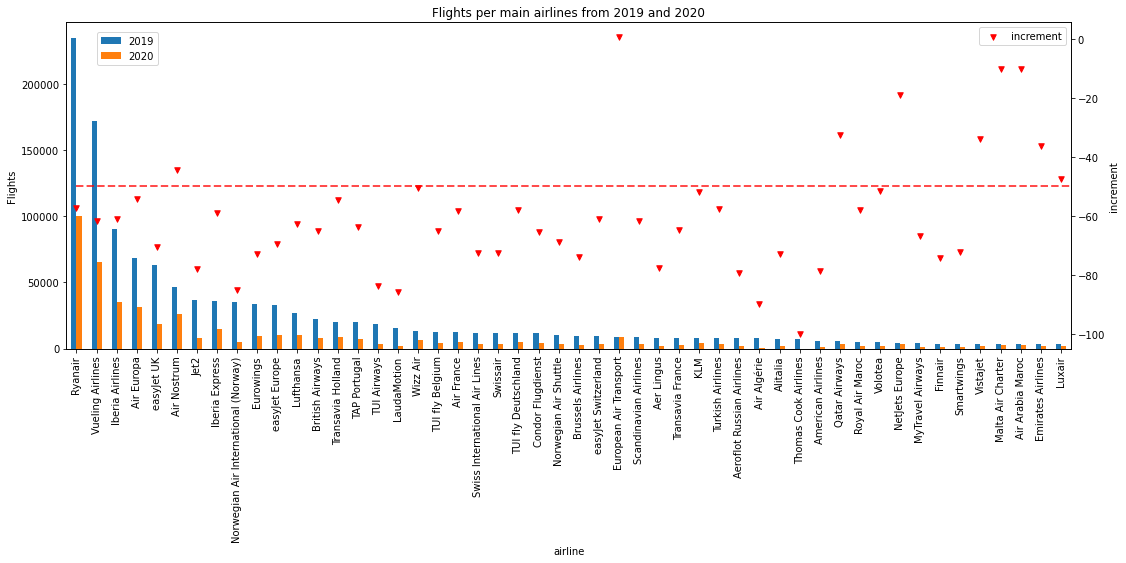

In [425]:
table_airlines = pd.pivot_table(df_esp[df_esp['year_']!=2021],values='flights',index=['airline'],columns=['year_'],aggfunc='sum')
table_airlines = table_airlines.sort_values(2019,ascending=False).iloc[0:50].fillna(0)
table_airlines.reset_index(inplace=True)
table_airlines['increment'] = np.round(((table_airlines[2020]-table_airlines[2019])/table_airlines[2019])*100,2)
ax_table_airlines = table_airlines.plot.bar(x='airline',y=[2019,2020],figsize=(18,6))
ax_table_airlines.set_ylabel("Flights",)
ax_table_airlines.set_title('Flights per main airlines from 2019 and 2020')
ax2 = ax_table_airlines.twinx()
table_airlines.plot(x='airline',y='increment',ax=ax2, color='r',kind='scatter',label='increment', marker='v',s=30,)
ax2.hlines(y=-50, xmin=0, xmax=len(table_airlines), linewidth=2, color='r',linestyles='--',alpha=0.7)
ax_table_airlines.legend(loc=(0.03,0.87))
ax2.legend(loc=0);

La línea de puntos roja muestra esa barrera en el gráfico, donde se ve como las 5 principales operadoras en españa, ***Ryanair, Vueling, Iberia, AirEuropa i easyJet***, todas ellas se encuentran por debajo de esta marca, acercandose a la cota del -60% de vuelos entre periodos.

Adelante veremos el análisis por mes de los vuelos realizados por las 5 operadoras más importantes en el mercado Español, comparando el ciclo de 2019 y 2020. 

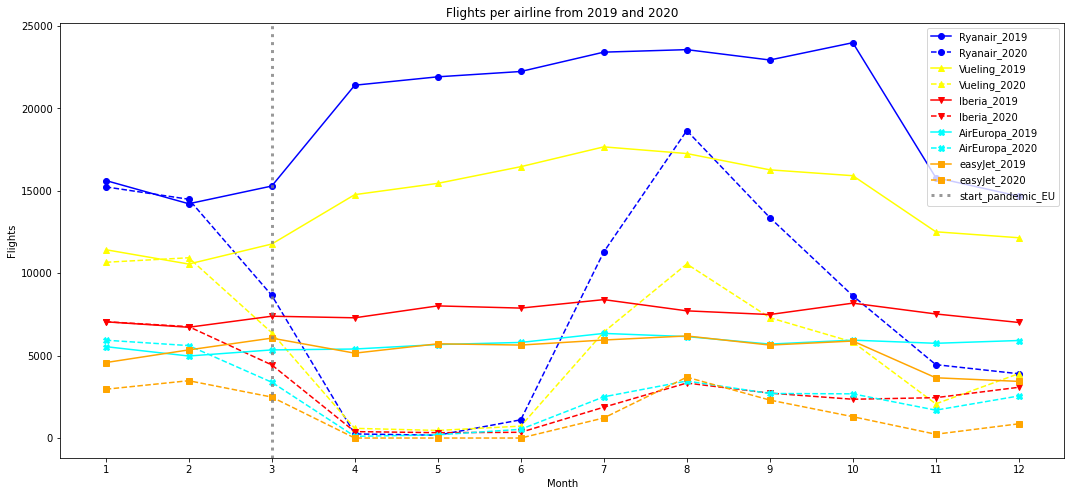

In [426]:
df_t_airlines_m = df_esp[(df_esp['year_']!=2021) & df_esp['airline'].isin(['Ryanair','Vueling Airlines', 'Iberia Airlines', 'Air Europa', 'easyJet UK'])]
t_airlines_m = pd.pivot_table(df_t_airlines_m,values='flights',index=['year_','month_'],columns=['airline'],aggfunc='sum').fillna(0)
t_airlines_m.reset_index(inplace=True)
t_airlines_m_19 = t_airlines_m.iloc[0:12]
t_airlines_m_20 = t_airlines_m.iloc[12:].reset_index()
plt.figure(figsize=(18,8))
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['Ryanair'],color='blue',label='Ryanair_2019',marker='o')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['Ryanair'],color='blue',label='Ryanair_2020',ls='--',marker='o')
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['Vueling Airlines'],color='yellow',label='Vueling_2019',marker='^')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['Vueling Airlines'],color='yellow',label='Vueling_2020',ls='--',marker='^')
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['Iberia Airlines'],color='red',label='Iberia_2019',marker='v')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['Iberia Airlines'],color='red',label='Iberia_2020',ls='--',marker='v')
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['Air Europa'],color='cyan',label='AirEuropa_2019',marker='X')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['Air Europa'],color='cyan',label='AirEuropa_2020',ls='--',marker='X')
plt.plot(t_airlines_m_19['month_'],t_airlines_m_19['easyJet UK'],color='orange',label='easyJet_2019',marker='s')
plt.plot(t_airlines_m_20['month_'],t_airlines_m_20['easyJet UK'],color='orange',label='easyJet_2020',ls='--',marker='s')
plt.title('Flights per airline from 2019 and 2020')
plt.ylabel('Flights')
plt.xlabel('Month')
plt.xticks(t_airlines_m_20['month_'])
plt.axvline(x=3,color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
plt.legend();

Oberve que durante el mes de **Febrero de 2020** ya empezamos a tener una decadencia de los vuelos, aumentando bruscamente en **Marzo de 2020** que es cuando la situación empieza a empeorar en el mundo ocasionando el *Lockdown* en diversos países, incluyendo España.

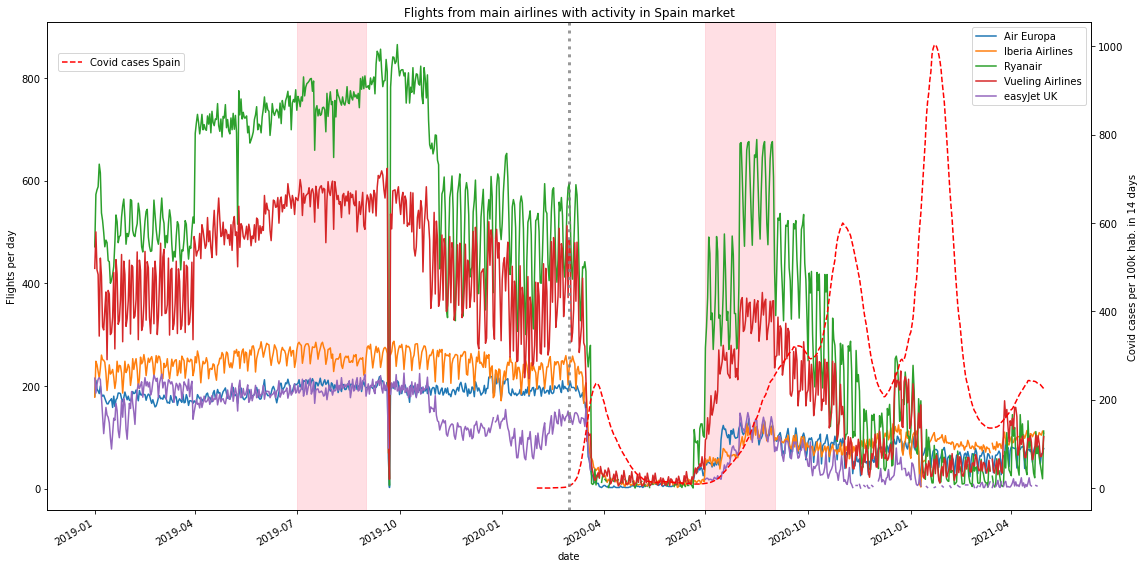

In [430]:
df_t_airlines_m = df_esp[df_esp['airline'].isin(['Ryanair','Vueling Airlines', 'Iberia Airlines', 'Air Europa', 'easyJet UK'])]
df_t_airlines_d = pd.pivot_table(df_t_airlines_m,values='flights',index=['date'],columns=['airline'],aggfunc='sum')

table_airlines =  pd.concat([df_t_airlines_d,df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
ax = table_airlines.drop('cases_14d_100k_hab_esp',axis=1).plot(figsize=(16,8))
ax2 = ax.twinx()
table_airlines['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights from main airlines with activity in Spain market")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.01,0.9))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

En el gráfico arriba analisamos la cantidad de vuelos y de COVID-19 para cada año, se encuentra destacado el periodo de verano donde hubo un aumento del número de vuelos en 2020. Se observa un aumento de los casos de COVID-19 en los meses seguientes al verano.

## Flights from and to Spain by continent and country

Otro punto importante es analisar las relaciones de España con otros países y continentes. Adelante veremos los análisis de estas relaciones.

In [126]:
df_routes = df_esp.copy()

In [127]:
df_routes.head()

,date,latitude_1,longitude_1,latitude_2,longitude_2,airline,airline_country,origin_region,destination_region,origin_city,destination_city,origin_continent,origin_country,destination_continent,destination_country,year_,month_,day_,flights
0,2019-01-01,-37.692123,144.841997,41.036124,2.063557,Air China,China,Victoria,Catalonia,Melbourne,Barcelona,Oceania,Australia,Europe,Spain,2019,1,1,1
1,2019-01-02,60.626541,41.002776,40.483418,-3.546173,Air China,China,Arkhangelskaya,Madrid,Podyuga,Madrid,Europe,Russian Federation,Europe,Spain,2019,1,2,1
2,2019-01-02,40.535614,-3.558960,54.301835,90.041282,Air China,China,Madrid,Khakasiya,Madrid,Tuim,Europe,Spain,Europe,Russian Federation,2019,1,2,1
3,2019-01-03,58.353378,42.201942,40.486237,-3.549037,Air China,China,Kostroma,Madrid,Galich,Madrid,Europe,Russian Federation,Europe,Spain,2019,1,3,1
4,2019-01-04,-37.690430,144.841705,41.064423,2.037415,Air China,China,Victoria,Catalonia,Melbourne,Barcelona,Oceania,Australia,Europe,Spain,2019,1,4,1


In [82]:
def continent_A(df):
    if df['origin_country']=='Spain':
        return df['origin_continent']
    else:
        return df['destination_continent']
    
def country_A(df):
    if df['origin_country']=='Spain':
        return df['origin_country']
    else:
        return df['destination_country']

def region_A(df):
    if df['origin_country']=='Spain':
        return df['origin_region']
    else:
        return df['destination_region']
    
def city_A(df):
    if df['origin_country']=='Spain':
        return df['origin_city']
    else:
        return df['destination_city']

######

def continent_B(df):
    if df['origin_country']!='Spain':
        return df['origin_continent']
    else:
        return df['destination_continent']
    
def country_B(df):
    if df['origin_country']!='Spain':
        return df['origin_country']
    else:
        return df['destination_country']

def region_B(df):
    if df['origin_country']!='Spain':
        return df['origin_region']
    else:
        return df['destination_region']
    
def city_B(df):
    if df['origin_country']!='Spain':
        return df['origin_city']
    else:
        return df['destination_city']

In [128]:
df_routes['continent_A'] = df_routes.apply(continent_A,axis=1)
df_routes['country_A']= df_routes.apply(country_A,axis=1)
df_routes['region_A']= df_routes.apply(region_A,axis=1)
df_routes['city_A']= df_routes.apply(city_A,axis=1)
df_routes['continent_B']= df_routes.apply(continent_B,axis=1)
df_routes['country_B']= df_routes.apply(country_B,axis=1)
df_routes['region_B']= df_routes.apply(region_B,axis=1)
df_routes['city_B']= df_routes.apply(city_B,axis=1)

In [129]:
df_routes.drop(['latitude_1','longitude_1','latitude_2','longitude_2',
                'origin_region','destination_region','origin_city','destination_city','origin_continent',
                'origin_country','destination_continent','destination_country'],axis=1,inplace=True)

In [130]:
df_routes = df_routes[df_routes['country_B']!='Spain']
df_routes.reset_index(drop=True,inplace=True)

In [131]:
df_routes

,date,airline,airline_country,year_,month_,day_,flights,continent_A,country_A,region_A,city_A,continent_B,country_B,region_B,city_B
0,2019-01-01,Air China,China,2019,1,1,1,Europe,Spain,Catalonia,Barcelona,Oceania,Australia,Victoria,Melbourne
1,2019-01-02,Air China,China,2019,1,2,1,Europe,Spain,Madrid,Madrid,Europe,Russian Federation,Arkhangelskaya,Podyuga
2,2019-01-02,Air China,China,2019,1,2,1,Europe,Spain,Madrid,Madrid,Europe,Russian Federation,Khakasiya,Tuim
3,2019-01-03,Air China,China,2019,1,3,1,Europe,Spain,Madrid,Madrid,Europe,Russian Federation,Kostroma,Galich
4,2019-01-04,Air China,China,2019,1,4,1,Europe,Spain,Catalonia,Barcelona,Oceania,Australia,Victoria,Melbourne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579800,2021-04-28,Aie Experience Flight,United Kingdom,2021,4,28,1,Europe,Spain,Madrid,Getafe,Europe,France,Provence-Alpes-Cote d'Azur,Istres/Le Tubé
1579801,2021-04-28,Aernord,Italy,2021,4,28,1,Europe,Spain,Madrid,Getafe,Europe,France,Provence-Alpes-Cote d'Azur,Istres/Le Tubé
1579802,2021-04-17,Mandarin Air,China,2021,4,17,1,Europe,Spain,Balearic Islands,Palma De Mallorca,Europe,Latvia,Babite,Riga
1579803,2021-04-18,Mandarin Air,China,2021,4,18,1,Europe,Spain,Balearic Islands,Palma De Mallorca,Europe,Switzerland,Geneva,Geneva


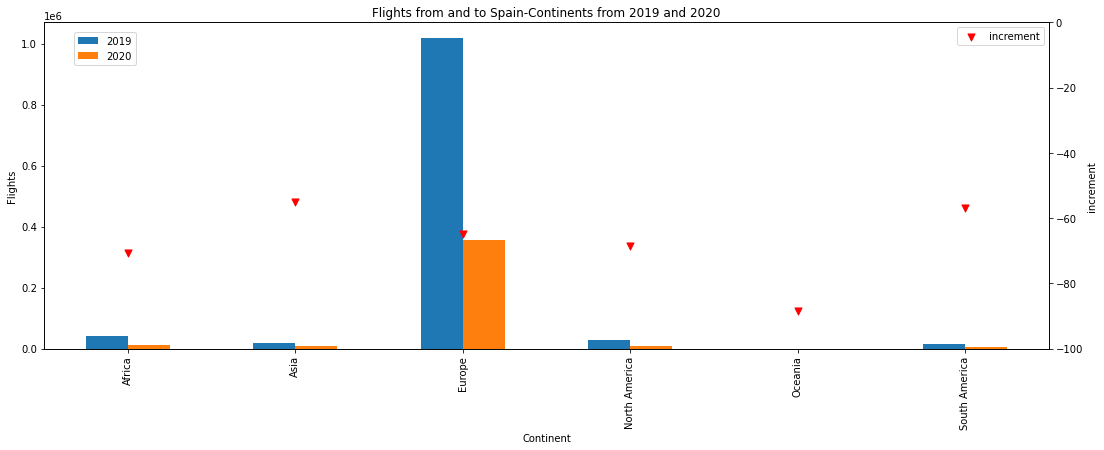

In [87]:
df_desti = df_routes[(df_routes['year_']!=2021)]
table_desti_con = pd.pivot_table(df_desti,values='flights',index=['continent_B'],columns=['year_'],aggfunc='sum').fillna(0)
table_desti_con.reset_index(inplace=True)
table_desti_con['increment'] = np.round(((table_desti_con[2020]-table_desti_con[2019])/table_desti_con[2019])*100,2)
ax_table_desti_con = table_desti_con.plot.bar(x='continent_B',y=[2019,2020],figsize=(18,6))
ax_table_desti_con.set_ylabel("Flights",)
ax_table_desti_con.set_xlabel("Continent",)
ax_table_desti_con.set_title('Flights from and to Spain-Continents from 2019 and 2020')
ax2 = ax_table_desti_con.twinx()
table_desti_con.plot(x='continent_B',y='increment',ax=ax2,kind='scatter',color='r',label='increment', marker='v',s=50,)
ax_table_desti_con.legend(loc=(0.03,0.87))
ax2.set_ylim([-100,0])
ax2.legend(loc=0);

Lo interesante es notar que todos los vuelos tuvieron una redución de más de 50% para todos los continentes. Con un mayor impacto en los continentes donde se habia un mayor descontrol y un mayor temor, relacionado a los casos de COVID-19.

A continuación se hace una comparativa de vuelos desde España a sus principales destinos y origenes:

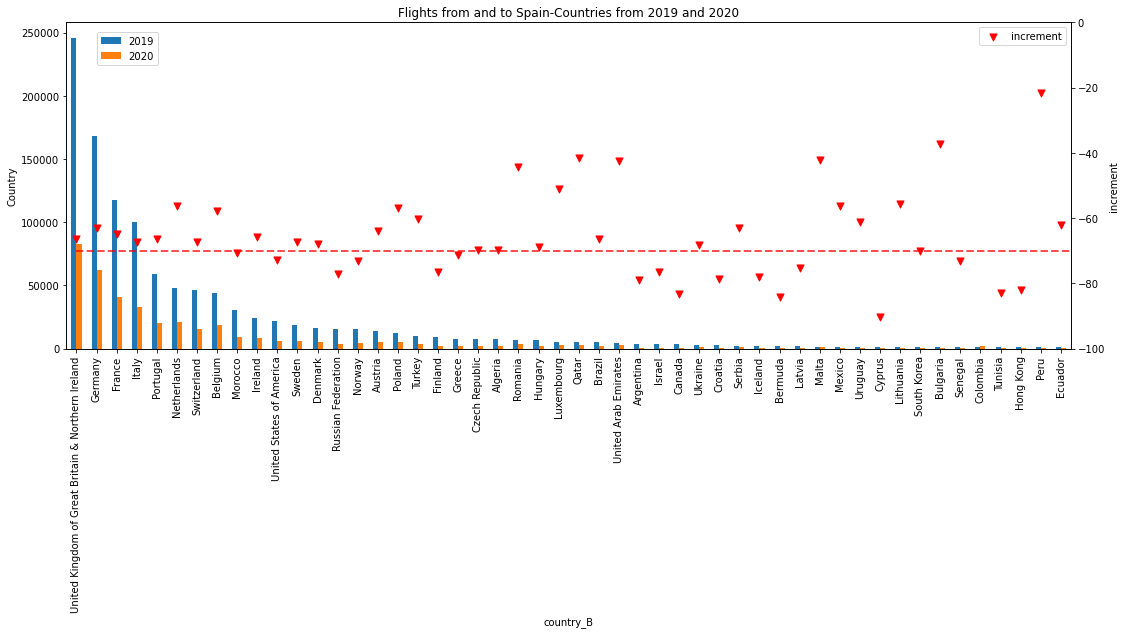

In [88]:
df_desti = df_routes[(df_routes['year_']!=2021)]
table_desti_con = pd.pivot_table(df_desti,values='flights',index=['country_B'],columns=['year_'],aggfunc='sum').fillna(0)
table_desti_con = table_desti_con.sort_values(2019,ascending=False).iloc[0:50].fillna(0)
table_desti_con.reset_index(inplace=True)
table_desti_con['increment'] = np.round(((table_desti_con[2020]-table_desti_con[2019])/table_desti_con[2019])*100,2)
ax_table_desti_con = table_desti_con.plot.bar(x='country_B',y=[2019,2020],figsize=(18,6))
ax_table_desti_con.set_ylabel("Flights",)
ax_table_desti_con.set_ylabel("Country",)
ax_table_desti_con.set_title('Flights from and to Spain-Countries from 2019 and 2020')
ax2 = ax_table_desti_con.twinx()
table_desti_con.plot(x='country_B',y='increment',ax=ax2,kind='scatter',color='r',label='increment', marker='v',s=50,)
ax_table_desti_con.legend(loc=(0.03,0.87))
ax2.set_ylim([-100,0])
ax2.legend(loc=0)
ax2.hlines(y=-70, xmin=0, xmax=len(table_desti_con), linewidth=2, color='r',linestyles='--',alpha=0.7);

Al observar el comportamiento aéreo de los principales países de destino y origen de España nos deparamos con una média de redución de 70% en la cantidad de vuelos.

Ahora se mirará el comportamiento de vuelos, a parte de la propria España, en los 6 principales países de origen y destino, son ellos: **Reino Unido, Alemania, Francia, Italia, Portugal y Países Bajos**. 

In [91]:
countries_cov = ['Spain'] + list(table_desti_con['country_B'].iloc[0:6])
countries_cov

['Spain',
 'United Kingdom of Great Britain & Northern Ireland',
 'Germany',
 'France',
 'Italy',
 'Portugal',
 'Netherlands']

In [433]:
table_desti_con_uk = pd.pivot_table(df_routes[df_routes['country_B'].isin(['United Kingdom of Great Britain & Northern Ireland','United Kingdom'])]
                                    ,values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_gr = pd.pivot_table(df_routes[df_routes['country_B'].isin(['Germany'])],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_fr = pd.pivot_table(df_routes[df_routes['country_B'].isin(['France'])],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_it = pd.pivot_table(df_routes[df_routes['country_B'].isin(['Italy'])],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_pt = pd.pivot_table(df_routes[df_routes['country_B'].isin(['Portugal'])],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_desti_con_nt = pd.pivot_table(df_routes[df_routes['country_B'].isin(['Netherlands'])],values='flights',index=['date'],aggfunc='sum').fillna(0)

table_desti_con_uk = pd.concat([table_desti_con_uk,df_covid_eu['cases_14d_100k_hab_uk'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_gr = pd.concat([table_desti_con_gr,df_covid_eu['cases_14d_100k_hab_gr'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_fr = pd.concat([table_desti_con_fr,df_covid_eu['cases_14d_100k_hab_fr'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_it = pd.concat([table_desti_con_it,df_covid_eu['cases_14d_100k_hab_it'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_pt = pd.concat([table_desti_con_pt,df_covid_eu['cases_14d_100k_hab_pt'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
table_desti_con_nt = pd.concat([table_desti_con_nt,df_covid_eu['cases_14d_100k_hab_nt'],df_covid_eu['cases_14d_100k_hab_esp']],axis=1)

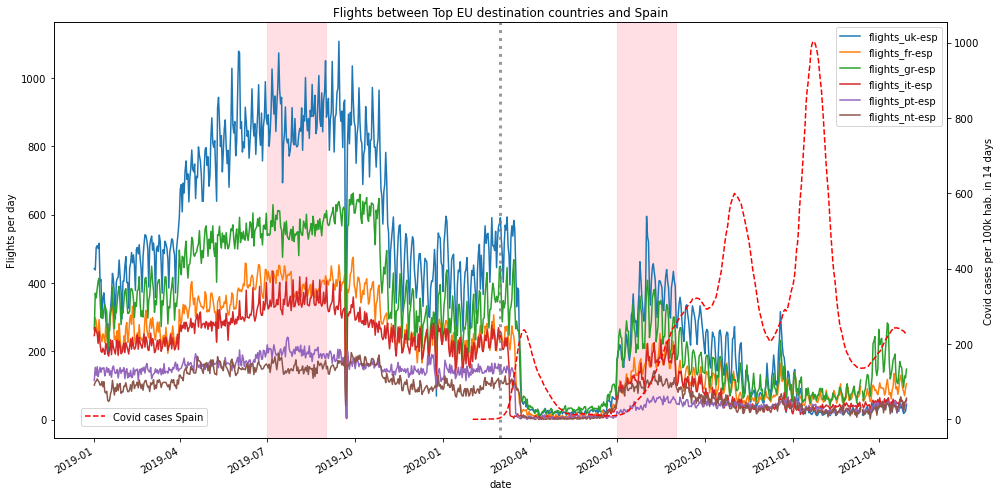

In [435]:
ax = table_desti_con_uk['flights'].plot(label='flights_uk-esp',figsize=(14,7))
table_desti_con_fr['flights'].plot(label='flights_fr-esp',ax=ax)
table_desti_con_gr['flights'].plot(label='flights_gr-esp',ax=ax)
table_desti_con_it['flights'].plot(label='flights_it-esp',ax=ax)
table_desti_con_pt['flights'].plot(label='flights_pt-esp',ax=ax)
table_desti_con_nt['flights'].plot(label='flights_nt-esp',ax=ax)
ax2 = ax.twinx()
table_desti_con_uk['cases_14d_100k_hab_esp'].plot(x='date',color='red',label='Covid cases Spain',style='--',ax=ax2)
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Top EU destination countries and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

Igual que vimos anteriormente se nota claramente un mismo comportamiento entre todos los países, en el gráfico se encuentra destacado el periodo de verano donde hubo un aumento del número de vuelos en 2020 observando un aumento de los casos de COVID-19 en los meses seguientes.

Se decidió analizar y comparar los vuelos y casos de covid entre estos países, juntamente con España, y observar si hubo el mismo comportamiento en el verano y en el post-verano. Abajo se encuentran todos los análisis seguido de una explicación general para todo, pues, como se puede percibir, los comportamientos son muy similares.

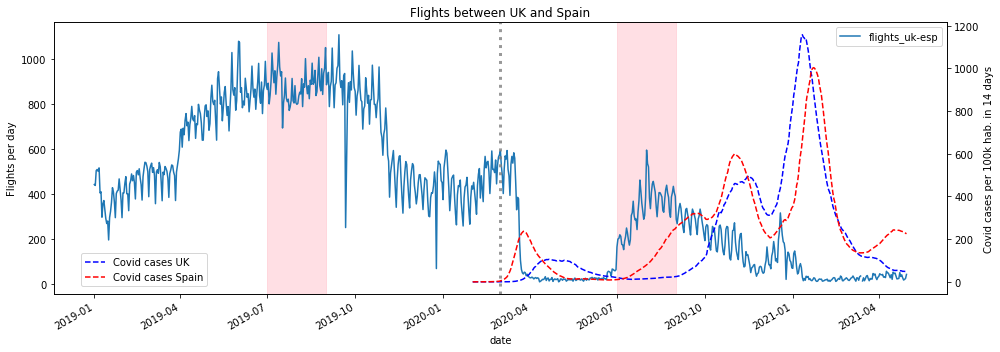

In [436]:
ax = table_desti_con_uk['flights'].plot(label='flights_uk-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_uk['cases_14d_100k_hab_uk'].plot(x='date',color='blue',style='--',ax=ax2,label='Covid cases UK')
table_desti_con_uk['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between UK and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

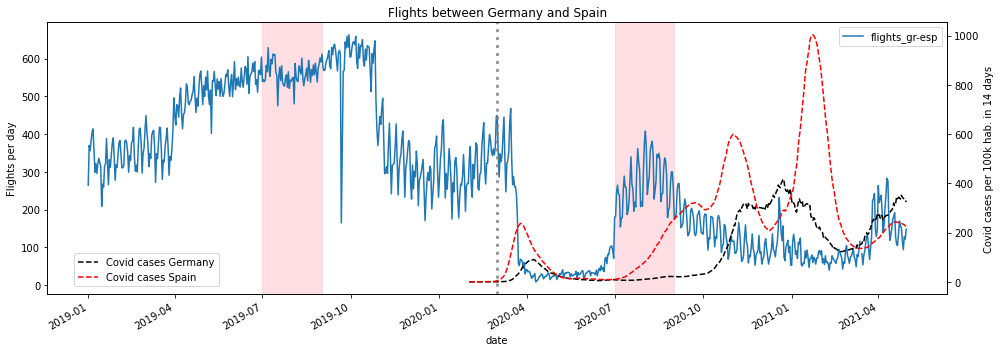

In [437]:
ax = table_desti_con_gr['flights'].plot(label='flights_gr-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_gr['cases_14d_100k_hab_gr'].plot(x='date',color='black',style='--',ax=ax2,label='Covid cases Germany')
table_desti_con_gr['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Germany and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

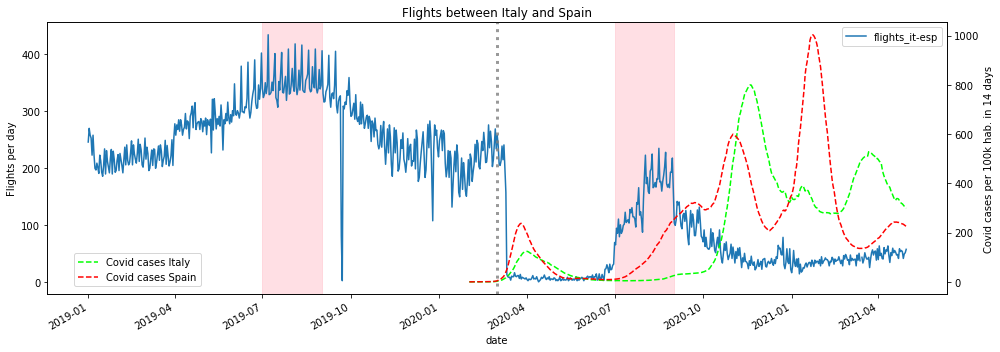

In [438]:
ax = table_desti_con_it['flights'].plot(label='flights_it-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_it['cases_14d_100k_hab_it'].plot(x='date',color='lime',style='--',ax=ax2,label='Covid cases Italy')
table_desti_con_it['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Italy and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

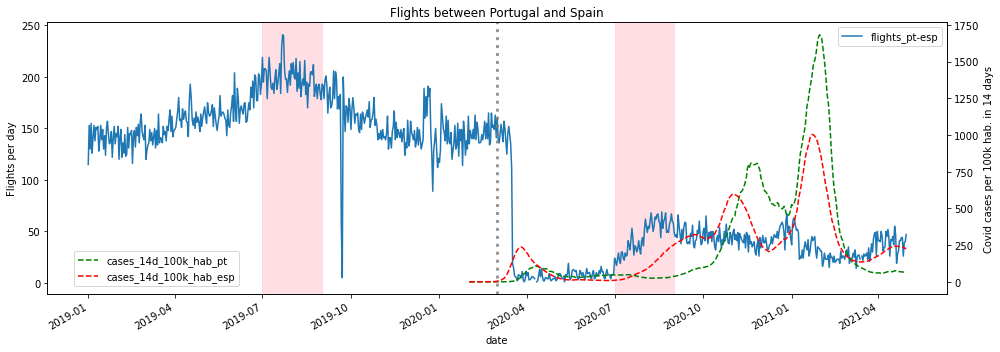

In [287]:
ax = table_desti_con_pt['flights'].plot(label='flights_pt-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_pt['cases_14d_100k_hab_pt'].plot(x='date',color='green',style='--',ax=ax2,label='Covid cases Portugal')
table_desti_con_pt['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Portugal and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

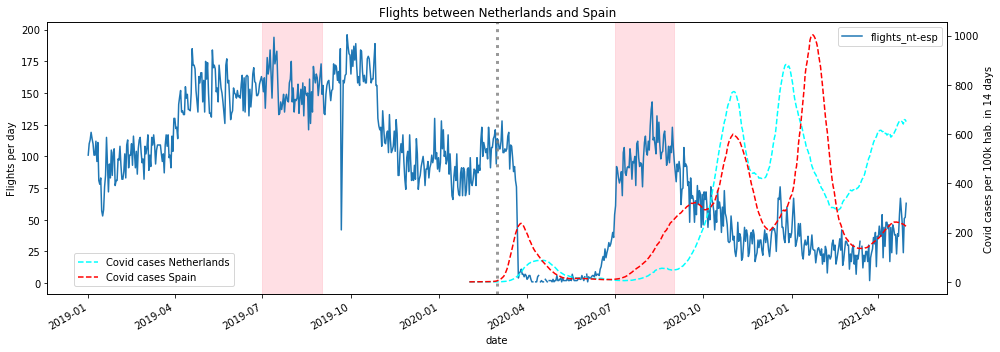

In [439]:
ax = table_desti_con_nt['flights'].plot(label='flights_nt-esp',figsize=(14,5))
ax2 = ax.twinx()
table_desti_con_nt['cases_14d_100k_hab_nt'].plot(x='date',color='cyan',style='--',ax=ax2,label='Covid cases Netherlands')
table_desti_con_nt['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Netherlands and Spain")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.03,0.03))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

Todos los países analisados, variando en intensidad y cantidad, tuvieron un comportamiento similar, un aumento de vuelos en el verano seguidos de un aumento considerable de COVID-19 en los meses posteriores, lo que nos indica una relación entre estes dos indicadores.

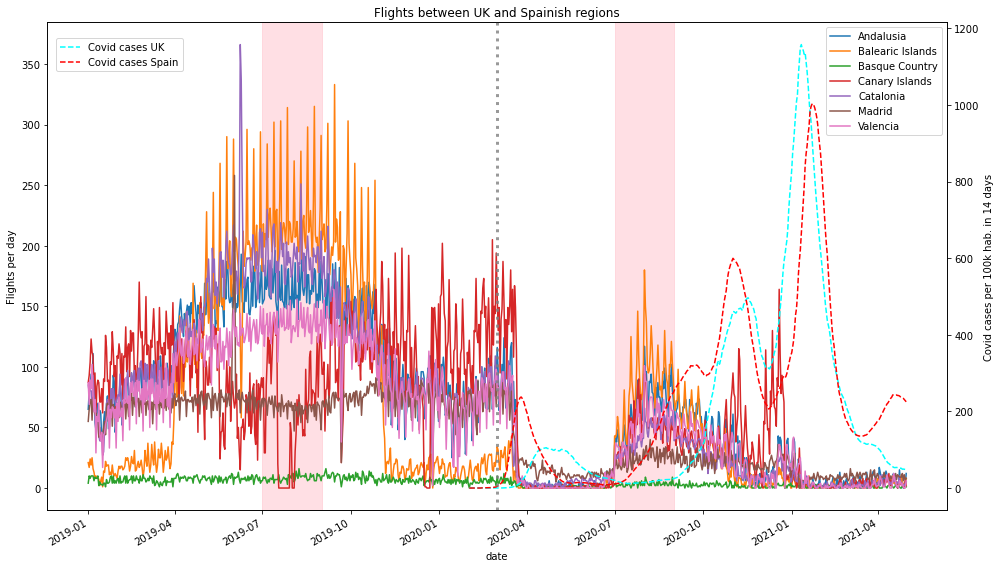

In [441]:
df_routes_reg = df_routes[df_routes['region_A'].isin(['Andalusia','Balearic Islands','Basque Country','Canary Islands','Catalonia','Madrid','Valencia'])]
table_desti_con_uk_reg = pd.pivot_table(df_routes_reg[df_routes_reg['country_B'].isin(['United Kingdom of Great Britain & Northern Ireland','United Kingdom'])]
                                    ,columns=['region_A'],values='flights',index=['date'],aggfunc='sum').fillna(0)

ax = table_desti_con_uk_reg.plot(figsize=(14,8))
ax2 = ax.twinx()
table_desti_con_uk['cases_14d_100k_hab_uk'].plot(x='date',color='cyan',style='--',ax=ax2,label='Covid cases UK')
table_desti_con_uk['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between UK and Spanish regions")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.01,0.9))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

## Internal air transport

Por ultimo, analisaremos los vuelos internos de España, sus principales destinos y origenes, comportamiento y relación entre los vuelos y el COVID-19

In [315]:
df_esp_reg = df_esp[(df_esp['origin_country']=='Spain') 
                    & (df_esp['destination_country']=='Spain') 
                    & (df_esp['origin_region']!=df_esp['destination_region'])]
df_esp_reg.reset_index(drop=True,inplace=True)
df_esp_reg.fillna('',inplace=True)
df_esp_reg['route_reg'] = df_esp_reg[['origin_region', 'destination_region']].agg('-'.join, axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [347]:
def order_region(x):
    l = x.split('-')
    r = min(l)+'-'+max(l)
    return r

In [349]:
df_esp_reg['route_reg'] = df_esp_reg['route_reg'].apply(order_region)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [351]:
df_esp_reg

,date,latitude_1,longitude_1,latitude_2,longitude_2,airline,airline_country,origin_region,destination_region,origin_city,destination_city,origin_continent,origin_country,destination_continent,destination_country,year_,month_,day_,flights,route_reg
0,2019-01-01,42.288798,-12.555776,40.4828,-3.54559,Air Europa,Spain,Galicia,Madrid,Fisterra,Madrid,Europe,Spain,Europe,Spain,2019,1,1,1,Galicia-Madrid
1,2019-01-01,40.519766,-3.574864,30.5754,-14.4651,Air Europa,Spain,Madrid,Canary Islands,Madrid,Tinajo,Europe,Spain,Europe,Spain,2019,1,1,1,Canary Islands-Madrid
2,2019-01-01,39.478500,2.569368,39.5245,0.529602,Air Europa,Spain,Balearic Islands,Valencia,Magaluf,Orpesa/Oropesa del Mar,Europe,Spain,Europe,Spain,2019,1,1,1,Balearic Islands-Valencia
3,2019-01-01,40.516891,-3.574890,28.5242,-16.467,Air Europa,Spain,Madrid,Canary Islands,Madrid,Tenerife,Europe,Spain,Europe,Spain,2019,1,1,1,Canary Islands-Madrid
4,2019-01-01,40.524701,-3.559445,41.32,1.51257,Air Europa,Spain,Madrid,Catalonia,Madrid,la Bisbal del Penedes,Europe,Spain,Europe,Spain,2019,1,1,1,Catalonia-Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358570,2021-04-14,37.417897,-5.900494,40.2783,-3.74457,Aernord,Italy,Andalusia,Madrid,Sevilla,Getafe,Europe,Spain,Europe,Spain,2021,4,14,1,Andalusia-Madrid
358571,2021-04-15,40.278946,-3.742615,37.4178,-5.96265,Aerotrans Airlines,Russia,Madrid,Andalusia,Getafe,Sevilla,Europe,Spain,Europe,Spain,2021,4,15,1,Andalusia-Madrid
358572,2021-04-15,40.278946,-3.742615,37.4178,-5.96265,Aie Experience Flight,United Kingdom,Madrid,Andalusia,Getafe,Sevilla,Europe,Spain,Europe,Spain,2021,4,15,1,Andalusia-Madrid
358573,2021-04-15,40.278946,-3.742615,37.4178,-5.96265,Aernord,Italy,Madrid,Andalusia,Getafe,Sevilla,Europe,Spain,Europe,Spain,2021,4,15,1,Andalusia-Madrid


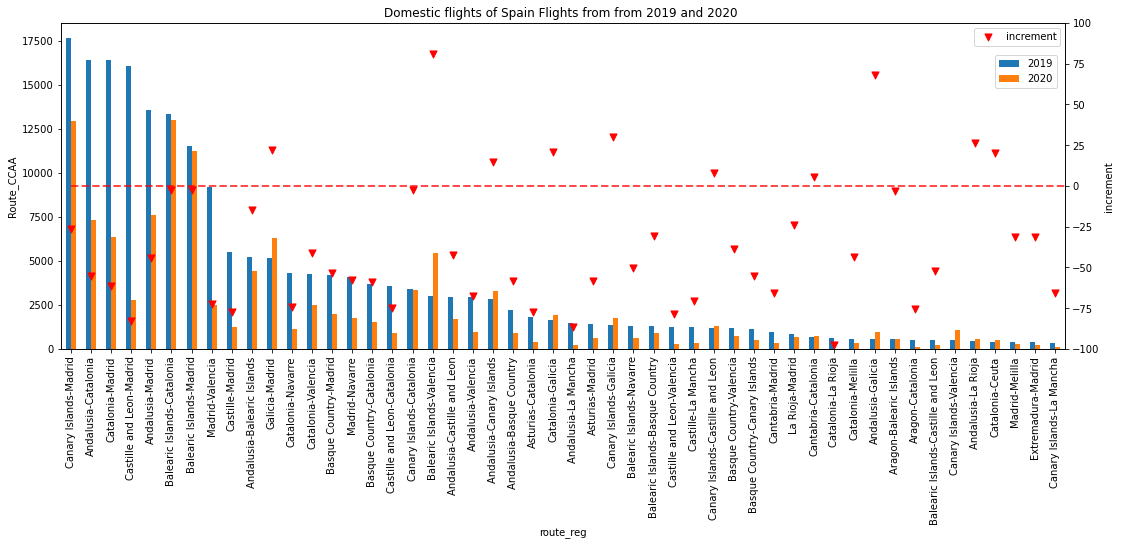

In [379]:
table_esp_reg_t = pd.pivot_table(df_esp_reg[df_esp_reg['year_']!=2021],index=['route_reg'],
                                 columns=['year_'],values='flights',
                                 aggfunc='sum').fillna(0).sort_values(by=2019,ascending=False).iloc[0:50].fillna(0)
table_esp_reg_t.reset_index(inplace=True)
table_esp_reg_t['increment'] = np.round(((table_esp_reg_t[2020]-table_esp_reg_t[2019])/table_esp_reg_t[2019])*100,2)
ax_table_esp_reg_t = table_esp_reg_t.plot.bar(x='route_reg',y=[2019,2020],figsize=(18,6))
ax_table_esp_reg_t.set_ylabel("Flights",)
ax_table_esp_reg_t.set_ylabel("Route_CCAA",)
ax_table_esp_reg_t.set_title('Domestic flights of Spain Flights from from 2019 and 2020 ')
ax2 = ax_table_esp_reg_t.twinx()
table_esp_reg_t.plot(x='route_reg',y='increment',ax=ax2,kind='scatter',color='r',label='increment', marker='v',s=50,)
ax_table_esp_reg_t.legend(loc=(0.93,0.8))
ax2.set_ylim([-100,100])
ax2.legend(loc=0);
ax2.hlines(y=0, xmin=0, xmax=len(table_esp_reg_t), linewidth=2, color='r',linestyles='--',alpha=0.7);

Entre los mayores destinos y origenes se encuentran justamente los destinos de verano más comunes. Interesante observar que muchas rutas obtuvierón un incremento de vuelos en 2020, lo que puede ser justificado por las diferentes restriciones adoptadas por cada Comunidad Autónoma. Adelante se encuentra una tabla con los destinos que obtuvieron un incremento entre 2019 y 2020, así como los que tuvieron menos de 5% de impacto en la redución de vuelos.

In [401]:
table_esp_reg_t[table_esp_reg_t['increment']>-5]

year_,route_reg,2019,2020,increment
5,Balearic Islands-Catalonia,13356.0,13042.0,-2.35
6,Balearic Islands-Madrid,11552.0,11259.0,-2.54
10,Galicia-Madrid,5167.0,6292.0,21.77
17,Canary Islands-Catalonia,3439.0,3363.0,-2.21
18,Balearic Islands-Valencia,3024.0,5479.0,81.18
21,Andalusia-Canary Islands,2848.0,3274.0,14.96
24,Catalonia-Galicia,1622.0,1955.0,20.53
27,Canary Islands-Galicia,1349.0,1755.0,30.10
32,Canary Islands-Castille and Leon,1210.0,1306.0,7.93
37,Cantabria-Catalonia,687.0,726.0,5.68


Seguiremos ahora con el comportamiento en el cronograma de vuelos por cada comunidad autónoma:

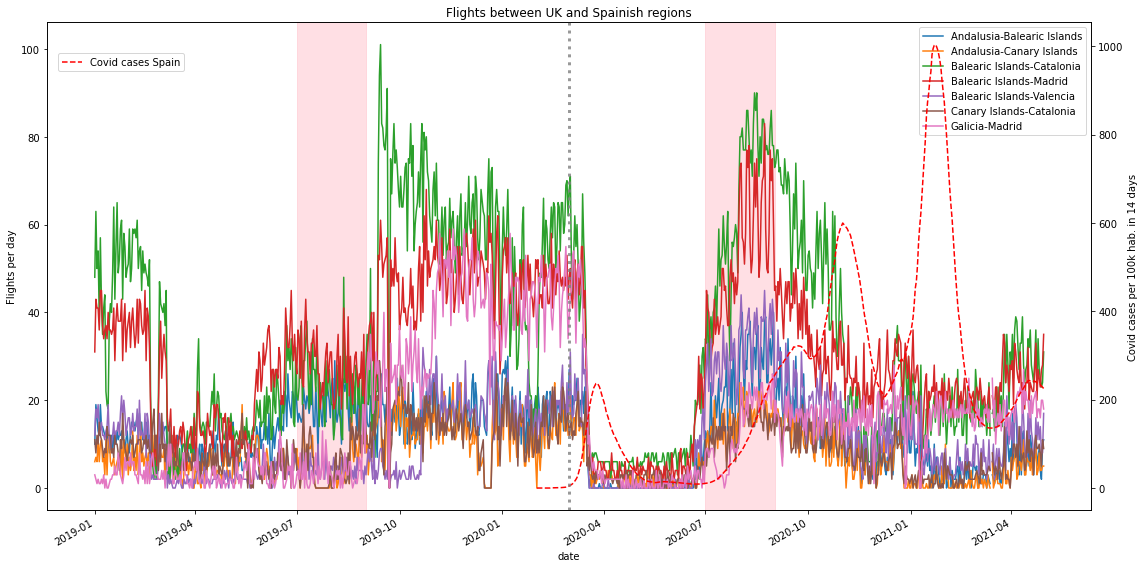

In [442]:
visited_ccaa = table_esp_reg_t['route_reg'][(table_esp_reg_t['increment']>-15) & (table_esp_reg_t[2020]>3000)]
table_esp_reg = pd.pivot_table(df_esp_reg[df_esp_reg['route_reg'].isin(visited_ccaa)],columns=['route_reg'],values='flights',index=['date'],aggfunc='sum').fillna(0)
table_esp_reg =  pd.concat([table_esp_reg,df_covid_eu['cases_14d_100k_hab_esp']],axis=1)
ax = table_esp_reg.drop('cases_14d_100k_hab_esp',axis=1).plot(figsize=(16,8))
ax2 = ax.twinx()
table_esp_reg['cases_14d_100k_hab_esp'].plot(x='date',color='red',style='--',ax=ax2,label='Covid cases Spain')
ax.set_ylabel("Flights per day",)
ax.set_title("Flights between Spanish regions")
ax2.set_ylabel("Covid cases per 100k hab. in 14 days")
ax.legend(loc=0)
ax2.legend(loc=(0.01,0.9))
plt.axvline(x='2020-03-01',color='grey',linewidth=3,alpha=0.8,ls=':',label='start_pandemic_EU')
ax.axvspan('2019-07-01', '2019-09-01', alpha=0.5, color='pink')
ax.axvspan('2020-07-01', '2020-09-01', alpha=0.5, color='pink')
plt.tight_layout()

Otra vez se oberva el mismo comportamiento, en todas las comunidades autónomas.

## Final Conclusion

Obeservamos el mismo comportamiento en todos los ámbitos analisados, sea diferentes aérolineas, países, rutas o Comunidades Autónomas, una decaída de vuelos desde **Febrero de 2020**, intensificada en **Marzo de 2020**, mucho por el miedo y los decretos de *Lockdown* en España y el mundo.
Con la queda de casos de COVID-19 en **Junio de 2020** se observa un aumento en la cantidad de vuelos a níveles altísimos  resultando en otra hola, incluso más grande que la primera.

Puntos que debemos destacar: <br>
1. Hay un mayor aumento de casos de COVID-19 después de las fiestas de navidad y año nuevo con una menor cantidad de vuelos que en verano, lo que nos lleva a creer que la mobilidad de las persona fue realizada por otros medios de transporte, como trenes, metro, coches, etc. Además una probable transmision entre familiares y personas de borbuja no muy distante. <br>
2. Algunas rutas resultaron en un incremiento en la cantidad de vuelos cuando comparadas con 2019, lo que nos lleva a pensar que mucho de esta disparidad es resultante de que las políticas de control epdemiológico son implementadas a nível autónomico, llevando a las personas buscaren otras alternativas de viaje. 